In [1]:
!pip install diffusers==0.3.0 --q
!pip install transformers scipy ftfy --q
!pip install "ipywidgets>=7,<8" --q
import IPython.display 


In [2]:

import gc
import torch
from PIL import Image
import IPython.display 
from torch import autocast
from tqdm.auto import tqdm
from kaggle_secrets import UserSecretsClient
from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import StableDiffusionPipeline
from diffusers import AutoencoderKL, UNet2DConditionModel
from diffusers import LMSDiscreteScheduler , PNDMScheduler


user_secrets = UserSecretsClient()
Hugging_face  = user_secrets.get_secret("Hugging_id")

In [3]:
class config : 
    DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
    HEIGHT = 512                        
    WIDTH = 512                         
    NUM_INFERENCE_STEPS = 500            
    GUIDANCE_SCALE = 7.5                
    GENERATOR = torch.manual_seed(48)   
    BATCH_SIZE = 1
    

In [4]:
def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols
    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

In [5]:
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae", use_auth_token=Hugging_face)
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14")
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet", use_auth_token=Hugging_face)
vae = vae.to(config.DEVICE)
text_encoder = text_encoder.to(config.DEVICE)
unet = unet.to(config.DEVICE) 


Downloading:   0%|          | 0.00/551 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/335M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/939k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/512k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/389 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/905 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.41k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.59G [00:00<?, ?B/s]

Some weights of the model checkpoint at openai/clip-vit-large-patch14 were not used when initializing CLIPTextModel: ['vision_model.encoder.layers.7.mlp.fc1.weight', 'vision_model.encoder.layers.12.mlp.fc1.weight', 'vision_model.encoder.layers.0.mlp.fc1.weight', 'vision_model.encoder.layers.5.self_attn.v_proj.weight', 'vision_model.encoder.layers.12.self_attn.q_proj.bias', 'vision_model.encoder.layers.20.mlp.fc1.bias', 'vision_model.encoder.layers.22.mlp.fc1.weight', 'vision_model.embeddings.position_embedding.weight', 'vision_model.encoder.layers.13.layer_norm1.weight', 'vision_model.encoder.layers.17.mlp.fc1.weight', 'vision_model.encoder.layers.0.layer_norm2.weight', 'vision_model.encoder.layers.4.self_attn.v_proj.weight', 'vision_model.encoder.layers.18.mlp.fc1.bias', 'vision_model.encoder.layers.9.mlp.fc2.weight', 'vision_model.encoder.layers.2.self_attn.k_proj.weight', 'vision_model.encoder.layers.21.layer_norm1.bias', 'vision_model.encoder.layers.20.mlp.fc2.weight', 'vision_mode

Downloading:   0%|          | 0.00/743 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

In [6]:
print(f'\033[94mTokenizer, Text Encoder, VAE, Unet are loaded !!')


Tokenizer, Text Encoder, VAE, Unet are loaded !!


In [7]:
scheduler = LMSDiscreteScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000)
print(f'\033[94mThe scheduler loaded is K-LMS Sceheduler')


The scheduler loaded is K-LMS Sceheduler


In [8]:
prompt = ["  futuristic synthwave city, retro sunset, crystals, spires, volumetric lighting, studio Ghibli style, rendered in unreal engine with clean details --ar 9:16 --hd --q 2"]

In [9]:
text_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
max_length = text_input.input_ids.shape[-1]
with torch.no_grad():
      text_embeddings = text_encoder(text_input.input_ids.to(config.DEVICE))[0]
uncond_input = tokenizer(
    [""] * config.BATCH_SIZE, padding="max_length", max_length=max_length, return_tensors="pt"
)
with torch.no_grad():
      uncond_embeddings = text_encoder(uncond_input.input_ids.to(config.DEVICE))[0]   
text_embeddings = torch.cat([uncond_embeddings, text_embeddings])
print(f'\033[94mText Embeddings shape: {text_embeddings.shape}')


Text Embeddings shape: torch.Size([2, 77, 768])


In [10]:
latents = torch.randn(
  (config.BATCH_SIZE, unet.in_channels, config.HEIGHT // 8, config.WIDTH // 8),
  generator=config.GENERATOR,
)
latents = latents.to(config.DEVICE)

print(f'\033[94mLatent shape: {latents.shape}')


Latent shape: torch.Size([1, 4, 64, 64])


In [11]:
scheduler.set_timesteps(config.NUM_INFERENCE_STEPS)
latents = latents * scheduler.sigmas[0]

In [12]:

with autocast(config.DEVICE):
      for i, t in tqdm(enumerate(scheduler.timesteps)):
        
        latent_model_input = torch.cat([latents] * 2)
        sigma = scheduler.sigmas[i]
        latent_model_input = latent_model_input / ((sigma**2 + 1) ** 0.5)

        with torch.no_grad():
              noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
        noise_pred = noise_pred_uncond + config.GUIDANCE_SCALE * (noise_pred_text - noise_pred_uncond)

        latents = scheduler.step(noise_pred, i, latents).prev_sample

0it [00:00, ?it/s]

In [13]:
latents = 1 / 0.18215 * latents

with torch.no_grad():
  image = vae.decode(latents).sample
print(f'\033[94mImage shape: {image.shape}')


Image shape: torch.Size([1, 3, 512, 512])


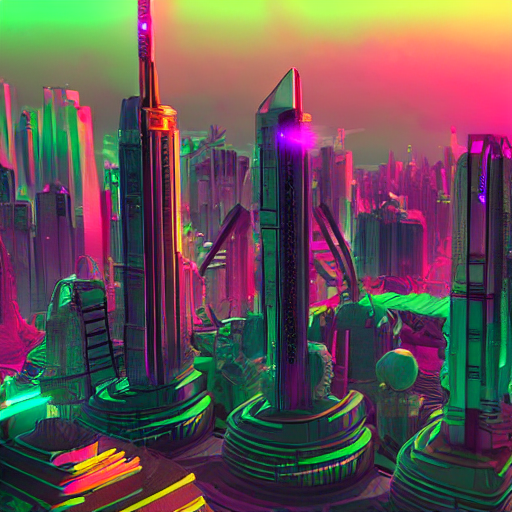

In [14]:
image = (image / 2 + 0.5).clamp(0, 1)
image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
images = (image * 255).round().astype("uint8")
pil_images = [Image.fromarray(image) for image in images]
pil_images[0]

In [15]:
prompt = ["a ultradetailed beautiful panting of a stylish short woman, wearing hijab, greg rutkowski and makoto shinkai, trending on artstation , 8k"]

In [16]:
text_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
max_length = text_input.input_ids.shape[-1]
with torch.no_grad():
      text_embeddings = text_encoder(text_input.input_ids.to(config.DEVICE))[0]
uncond_input = tokenizer(
    [""] * config.BATCH_SIZE, padding="max_length", max_length=max_length, return_tensors="pt"
)
with torch.no_grad():
      uncond_embeddings = text_encoder(uncond_input.input_ids.to(config.DEVICE))[0]   
text_embeddings = torch.cat([uncond_embeddings, text_embeddings])
print(f'\033[94mText Embeddings shape: {text_embeddings.shape}')


Text Embeddings shape: torch.Size([2, 77, 768])


In [17]:
latents = torch.randn(
  (config.BATCH_SIZE, unet.in_channels, config.HEIGHT // 8, config.WIDTH // 8),
  generator=config.GENERATOR,
)
latents = latents.to(config.DEVICE)

print(f'\033[94mLatent shape: {latents.shape}')


Latent shape: torch.Size([1, 4, 64, 64])


In [18]:
scheduler.set_timesteps(config.NUM_INFERENCE_STEPS)
latents = latents * scheduler.sigmas[0]

In [19]:

with autocast(config.DEVICE):
      for i, t in tqdm(enumerate(scheduler.timesteps)):
        
        latent_model_input = torch.cat([latents] * 2)
        sigma = scheduler.sigmas[i]
        latent_model_input = latent_model_input / ((sigma**2 + 1) ** 0.5)

        with torch.no_grad():
              noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
        noise_pred = noise_pred_uncond + config.GUIDANCE_SCALE * (noise_pred_text - noise_pred_uncond)

        latents = scheduler.step(noise_pred, i, latents).prev_sample

0it [00:00, ?it/s]

In [20]:
latents = 1 / 0.18215 * latents

with torch.no_grad():
  image = vae.decode(latents).sample
print(f'\033[94mImage shape: {image.shape}')


Image shape: torch.Size([1, 3, 512, 512])


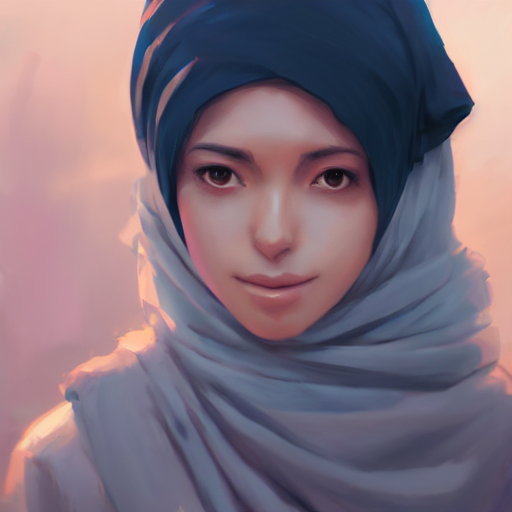

In [21]:
image = (image / 2 + 0.5).clamp(0, 1)
image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
images = (image * 255).round().astype("uint8")
pil_images = [Image.fromarray(image) for image in images]
pil_images[0].save("img17.jpg")
pil_images[0]

In [22]:
del latents
del vae
del text_encoder
del unet
gc.collect()

188

In [23]:
pipe = StableDiffusionPipeline.from_pretrained("CompVis/stable-diffusion-v1-4", revision="fp16", torch_dtype=torch.float16, use_auth_token=Hugging_face)  
pipe = pipe.to(config.DEVICE)
print(f'\033[94mStable Diffusion Pipeline created !!!')


Downloading:   0%|          | 0.00/1.34k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/12.5k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/342 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/543 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.63k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/608M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/209 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/307 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/572 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/246M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/525k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/472 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/788 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/772 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.72G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/71.2k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/550 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/167M [00:00<?, ?B/s]

Stable Diffusion Pipeline created !!!


In [24]:
# Save the pipeline to a file
torch.save(pipe, "stable_diffusion_pipeline.pth")

print("Stable Diffusion Pipeline saved successfully.")

Stable Diffusion Pipeline saved successfully.


  0%|          | 0/201 [00:00<?, ?it/s]

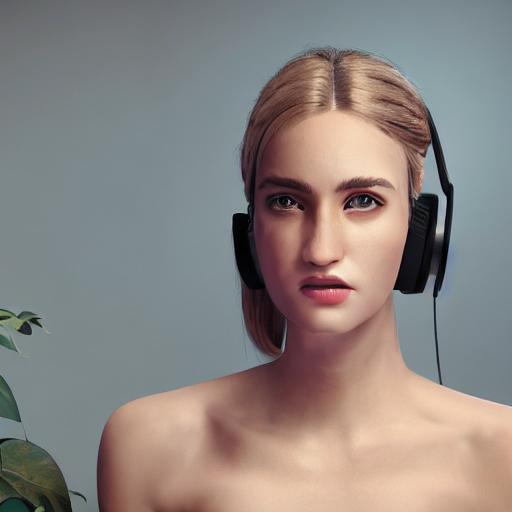

In [25]:
num_images = 1
prompt = ["gorgeous young Swiss girl sitting with headphones on, wearing dress , soft lips, beach blonde hair, octane render, unreal engine, photograph, realistic skin texture, photorealistic, hyper realism, highly detailed, 85mm portrait photography, award winning, hard rim lighting photography–beta –ar 9:16 –s 5000 –testp –upbeta –upbeta –upbeta "] * num_images
with autocast("cuda"):
  images = pipe(prompt , num_inference_steps=200).images

grid = image_grid(images, rows=1, cols=1)
grid

In [26]:
grid.save("img14.jpg")

  0%|          | 0/201 [00:00<?, ?it/s]

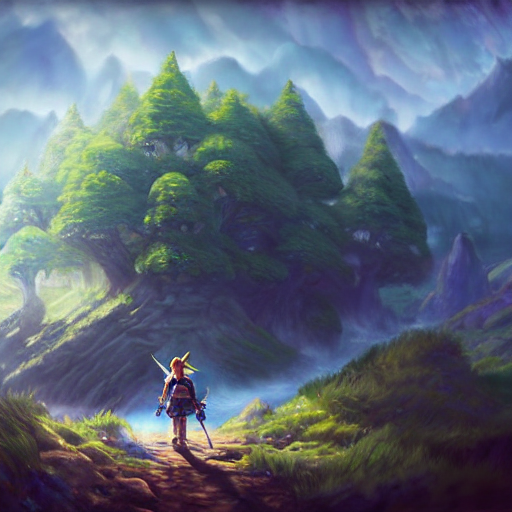

In [27]:
num_images = 1
prompt =["The Legend of Zelda landscape atmospheric, hyper realistic, 8k, epic composition, cinematic, octane render, artstation landscape vista photography by Carr Clifton & Galen Rowell, 16K resolution, Landscape veduta photo by Dustin Lefevre & tdraw, 8k resolution, detailed landscape painting by Ivan Shishkin, DeviantArt, Flickr, rendered in Enscape, Miyazaki, Nausicaa Ghibli, Breath of The Wild, 4k detailed post processing, artstation, rendering by octane, unreal engine —ar 16:9"] * num_images
with autocast("cuda"):
  images = pipe(prompt , num_inference_steps=200).images

grid2 = image_grid(images, rows=1, cols=1)
grid2

In [28]:
grid2.save("img15.jpg")

  0%|          | 0/201 [00:00<?, ?it/s]

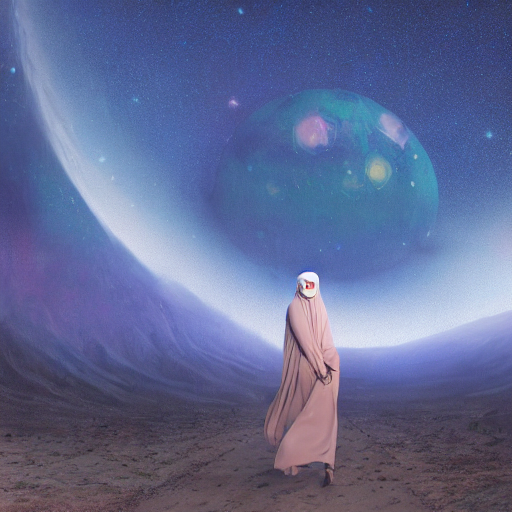

In [29]:
num_images = 1
prompt =[" beautiful girl wearing hijab walking on the starlight,dreamy ultra wide shot, atmospheric, hyper realistic, epic composition, cinematic, octane render, artstation landscape vista photography by Carr Clifton & Galen Rowell, 16K resolution, Landscape veduta photo by Dustin Lefevre & tdraw, detailed landscape painting by Ivan Shishkin, DeviantArt, Flickr, rendered in Enscape, Miyazaki, Nausicaa Ghibli, Breath of The Wild, 4k detailed post processing, artstation, rendering by octane, unreal engine –iw 10 –ar 9:16"] * num_images
with autocast("cuda"):
  images = pipe(prompt , num_inference_steps=200).images

grid3 = image_grid(images, rows=1, cols=1)
grid3

In [30]:
grid3.save("img16.jpg")